In [388]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import time
import random
pd.set_option('display.max_columns', 50)

adj_jpm = pd.DataFrame.from_csv('adjJPM.csv')
display(adj_jpm.head())

,Open,High,Low,Close,Volume,Adj Close
1983-12-30,2.602623,2.632198,2.573048,44.000008,3.575624e+06,2.602623
1984-01-03,2.598926,2.617409,2.580440,44.000008,6.517272e+06,2.602623
1984-01-04,2.652532,2.713529,2.617410,45.874979,4.945011e+06,2.713529
1984-01-05,2.768984,2.802256,2.735712,47.375008,5.817363e+06,2.802256
1984-01-06,2.772681,2.802256,2.743106,46.875014,3.286531e+06,2.772681


In [389]:
from os import listdir

# Get stock names
symbol_list = [filename[:-4] for filename in listdir('../Forecaster/stock_data/') if filename[-3:] == 'csv']

# Remove sp500.csv
symbol_list.remove('sp500')

In [390]:
# Load stock data
stock_dict = {}

for symbol in symbol_list:
    stock_dict[symbol] = pd.DataFrame.from_csv('../Forecaster/stock_data/' + symbol + '.csv')

In [391]:
from copy import deepcopy

def adjust_price_volume(df):
    
    df['adj_factor'] = df['Adj Close'] / df['Close']
    df['Open'] = df['Open'] * df['adj_factor']
    df['High'] = df['High'] * df['adj_factor']
    df['Low'] = df['Low'] * df['adj_factor']
    df['Volume'] = df['Volume'] / df['adj_factor']

In [392]:
def create_label_column(df):
    
    df['Adj Close shift'] = df['Adj Close'].shift(-1)

In [393]:
def create_next_day_open(df):
    
    df['Open shift'] = df['Open'].shift(-1)

In [394]:
def create_diffs(df):
    
    df['high_diff'] = df['High'] - df['Adj Close shift']
    df['low_diff'] = df['Low'] - df['Adj Close shift']
    df['close_diff'] = df['Adj Close'] - df['Adj Close shift']
    df['open_diff'] = df['Open shift'] - df['Adj Close shift']

In [395]:
def preprocess(dataframe):
    df = deepcopy(dataframe)
    
    adjust_price_volume(df)
    create_label_column(df)
    create_next_day_open(df)
    create_diffs(df)
    
    df.dropna(inplace=True)
    
    return df

In [396]:
# Adjust prices and volumes
for symbol in symbol_list:
    stock_dict[symbol] = preprocess(stock_dict[symbol])

In [397]:
stock_dict['JPM'].head()

,Open,High,Low,Close,Volume,Adj Close,adj_factor,Adj Close shift,Open shift,high_diff,low_diff,close_diff,open_diff
Date,,,,,,,,,,,,,
2009-01-02,26.706084,27.091389,26.089590,31.350000,3.795075e+07,26.843081,0.856239,25.044979,26.312212,2.046410,1.044611,1.798102,1.267233
2009-01-05,26.312212,26.346462,24.899418,29.250000,5.146860e+07,25.044979,0.856239,25.584409,25.507349,0.762053,-0.684991,-0.539430,-0.077060
2009-01-06,25.507349,26.046779,25.267602,29.879999,5.164016e+07,25.584409,0.856239,24.051743,24.959356,1.995036,1.215859,1.532666,0.907613
2009-01-07,24.959356,25.173416,23.974682,28.090000,4.923452e+07,24.051743,0.856239,23.306814,23.889057,1.866602,0.667868,0.744929,0.582243
2009-01-08,23.889057,23.931870,22.998570,27.219999,6.081926e+07,23.306814,0.856239,22.236516,23.589373,1.695354,0.762054,1.070298,1.352857


In [398]:
from numpy.linalg import inv

class Kalman(object):
    def __init__(self, init_price, noise=1):
        self.dt = 1 # time scale
        self.noise = noise
        
        self.x = np.array([init_price, 0]) # State vector: [price, price_rate] (2x1)
#         self.x = np.array([init_price, 0, 0]) # State vector: [price, price_rate, price_rate2] (3x1)
        self.P = np.array([[1, 0], [0, 1]]) # Uncertainty covariance matrix (2x2)
#         self.P = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]]) # Uncertainty covariance matrix (3x3)
        
        self.F = np.array([[1, self.dt], [0, 1]]) # Prediction matrix (2x2)
#         self.F = np.array([[1, self.dt, 0.5 * self.dt**2], [0, 1, self.dt], [0, 0, 1]]) # Prediction matrix (2x2)
    
        self.Q = np.array([[noise, 0], [0, noise]]) # Unpredictable external factor noice covariance matrix (2x2)
#         self.Q = np.array([[noise, 0, 0], [0, noise, 0], [0, 0, noise]]) # Unpredictable external factor noice covariance matrix (3x3)
        
        self.H = np.array([1, 0]) # Measurement mapping function (1x2)
#         self.H = np.array([1, 0, 0]) # Measurement mapping function (1x3)
        
        self.R_h = None # Sensor noice covariance (scalar)
        self.R_l = None # Sensor noice covariance (scalar)
        self.R_c = None # Sensor noice covariance (scalar)
        self.R_o = None # Sensor noice covariance (scalar)   
        
        self.S = None # Fusion (scalar)
        
        self.y = None # error (scalar)
        self.K = None # Kalman gain (2x1)
#         self.K = None # Kalman gain (3x1)
        
    def predict(self):
        self.x = np.matmul(self.F, self.x) # Predict today's adj close
        self.P = np.matmul(np.matmul(self.F, self.P), self.F.T) + self.Q
    
    def update(self, measurement, sensor_type):
        self.y = measurement - np.matmul(self.H, self.x) # Calculate loss
        
        if sensor_type == 'high':
            self.S = np.matmul(np.matmul(self.H, self.P), self.H.T) + self.R_h
        elif sensor_type == 'low':
            self.S = np.matmul(np.matmul(self.H, self.P), self.H.T) + self.R_l
        elif sensor_type == 'close':
            self.S = np.matmul(np.matmul(self.H, self.P), self.H.T) + self.R_c
        else:
            self.S = np.matmul(np.matmul(self.H, self.P), self.H.T) + self.R_o
            
#         K = np.matmul(self.P, self.H.T) * (1/S) # Calculate Kalman gain (2x1)
        self.K = np.matmul(self.P, self.H.T) * (1/self.S) # Calculate Kalman gain (3x1)
        
        # Update x and P
        self.x = self.x + self.K * self.y
        self.P = np.matmul(np.eye(2, 2) - np.matmul(self.K, self.H), self.P)
#         self.P = np.matmul(np.eye(3, 3) - np.matmul(self.K, self.H), self.P)

In [399]:
kalman_dict = {} # Key: symbol, Value: (init_price, kalman object)

for symbol in symbol_list:
    init_price = stock_dict[symbol].ix[0, 0]
    kalman_dict[symbol] = init_price, Kalman(init_price)

In [400]:
prediction_dict = {}
symbol_count = 0

for symbol in symbol_list:
    symbol_count += 1
    
    stock = stock_dict[symbol]
    kalman = kalman_dict[symbol][1]
    
    prediction = []
    counter = 0

    for i, r in stock.iterrows():
        (u,) = stock.index.get_indexer_for([i])

        # Keep track of number of days
        counter += 1
        # Start from the 127th day of data
        if counter > 126:
            # Calculate variance
            high_var126 = stock.ix[u-126:u, 'high_diff'].std()**2
            low_var126 = stock.ix[u-126:u, 'low_diff'].std()**2
            close_var126 = stock.ix[u-126:u, 'close_diff'].std()**2
            open_var126 = stock.ix[u-126:u, 'open_diff'].std()**2

            kalman.R_h = high_var126
            kalman.R_l = low_var126 
            kalman.R_c = close_var126
            kalman.R_o = open_var126

            # Predict
            kalman.predict()

            # Measurement Update
            # Update using High
            kalman.update(measurement=r['High'], sensor_type='high')

            # Update using High
            kalman.update(measurement=r['Low'], sensor_type='high')

            # Update using High
            kalman.update(measurement=r['Adj Close'], sensor_type='close')

            # Update using High
            kalman.update(measurement=r['Open shift'], sensor_type='open')

            prediction.append(kalman.x[0])
            
    prediction_dict[symbol] = prediction
    
    print(symbol_count, symbol)

1 SUNE
2 TXT
3 MS
4 KLAC
5 KEY
6 MET
7 GHC
8 ADP
9 ACAS
10 BTU
11 DRI
12 STI
13 NDAQ
14 FAST
15 FLR
16 ODP
17 BHI
18 USB
19 SBUX
20 ZION
21 IR
22 CME
23 SE
24 TAP
25 CF
26 TRV
27 GAS
28 EBAY
29 MAS
30 AON
31 APH
32 MMC
33 RRC
34 GPC
35 ZBH
36 AMAT
37 MAR
38 PKI
39 WY
40 NYT
41 L
42 XRX
43 RL
44 JWN
45 TSO
46 WEC
47 JNJ
48 K
49 NSC
50 TLAB
51 BLL
52 MRO
53 RSG
54 MCHP
55 WBA
56 CSC
57 GM
58 NTRS
59 CTSH
60 MMM
61 DTE
62 EQR
63 ADI
64 GNW
65 PNC
66 HPQ
67 SLM
68 PBCT
69 CMCSA
70 SRCL
71 BBY
72 NWL
73 LUV
74 ETR
75 BSX
76 MWW
77 MSI
78 CNP
79 PPG
80 POM
81 ANF
82 PCAR
83 CTAS
84 BDX
85 SYMC
86 GWW
87 JEC
88 ECL
89 ETFC
90 AIV
91 COST
92 PG
93 NE
94 BMS
95 FE
96 AMZN
97 UNM
98 SYY
99 MO
100 A
101 MHFI
102 GPS
103 PH
104 MON
105 AA
106 T
107 COH
108 NOV
109 CA
110 HON
111 AMT
112 WMT
113 BXP
114 GOOG
115 TSS
116 CCL
117 BK
118 NVDA
119 MAT
120 APOL
121 QCOM
122 LB
123 JBL
124 NKE
125 CVS
126 CNX
127 D
128 CLX
129 GD
130 LEG
131 CB
132 KIM
133 ALL
134 CEG
135 STR
136 AVY
137 TSN
138 KSS
139 

In [407]:
stock_dict['SUNE'].head()

,Open,High,Low,Close,Volume,Adj Close,adj_factor,Adj Close shift,Open shift,high_diff,low_diff,close_diff,open_diff
Date,,,,,,,,,,,,,
2009-01-02,14.330000,15.760000,14.330000,15.660000,4126700.0,15.660000,1.0,15.760000,15.450000,0.000000,-1.430000,-0.100000,-0.310000
2009-01-05,15.450000,15.940000,15.150000,15.760000,4848700.0,15.760000,1.0,17.690001,15.310000,-1.750001,-2.540001,-1.930001,-2.380001
2009-01-06,15.310000,17.809999,14.770000,17.690001,9751000.0,17.690001,1.0,17.100000,17.260000,0.709999,-2.330000,0.590001,0.160000
2009-01-07,17.260000,17.260000,16.610001,17.100000,6741000.0,17.100000,1.0,16.570000,16.110001,0.690000,0.040001,0.530000,-0.459999
2009-01-08,16.110001,16.670000,15.790000,16.570000,4321800.0,16.570000,1.0,16.469999,16.549999,0.200001,-0.679999,0.100001,0.080000


In [418]:
from sklearn.metrics import r2_score

y_true_dict = {}
comparison_dict = {}
r2_dict = {}

for symbol in symbol_list:
    y_true_dict[symbol] = stock_dict[symbol].iloc[126:, 7]
    comparison_dict[symbol] = (stock_dict[symbol].iloc[126:, 5], prediction_dict[symbol])
    r2_dict[symbol] = (r2_score(y_true_dict[symbol], comparison_dict[symbol][0]), r2_score(y_true_dict[symbol], comparison_dict[symbol][1]))

In [421]:
# print(len(y_true_dict['SUNE']))
# print(len(comparison_dict['SUNE'][0]))

# print(y_true_dict['SUNE'][:10])
# print(comparison_dict['SUNE'][0][:10])
# print(r2_score(y_true_dict['SUNE'], comparison_dict['SUNE'][0]))
# print(len(comparison_dict['SUNE'][1]))

print(r2_dict['SUNE'])

(0.99533123749863428, 0.99649042704947333)


In [425]:
naive_series = pd.Series([r2_dict[symbol][0] for symbol in r2_dict])
naive_avg = np.mean(naive_series)
naive_std = np.std(naive_series)

kalman_series = pd.Series([r2_dict[symbol][1] for symbol in r2_dict])
# kalman_avg = np.mean(kalman_series)
# kalman_std = np.std(kalman_series)

In [491]:
bad_symbols = [symbol for symbol in r2_dict if r2_dict[symbol][1] < 0.95]
bad_symbols.extend([symbol for symbol in r2_dict if r2_dict[symbol][0] < 0.95])

good_symbols = [symbol for symbol in r2_dict if symbol not in bad_symbols]

In [492]:
print(bad_symbols)

['WYNN', 'GOOG', 'AZO', 'GS', 'AMZN', 'LUK', 'PCP', 'ICE', 'WHR', 'GOOGL', 'PXD', 'TIE', 'RL', 'GWW', 'GHC', 'ISRG', 'BTU']


In [487]:
naive_list = [r2_dict[symbol][0] for symbol in good_symbols]
kalman_list = [r2_dict[symbol][1] for symbol in good_symbols]
naive_series = pd.Series(naive_list)
kalman_series = pd.Series(kalman_list)

In [488]:
# print([symbol for symbol in r2_dict if r2_dict[symbol][0] < 0.9])

In [489]:
naive_series.describe()

count    431.000000
mean       0.995838
std        0.003669
min        0.970153
25%        0.994538
50%        0.996941
75%        0.998395
max        0.999473
dtype: float64

In [490]:
kalman_series.describe()

count    431.000000
mean       0.996934
std        0.002941
min        0.977491
25%        0.996343
50%        0.997879
75%        0.998865
max        0.999620
dtype: float64

In [427]:
kalman_series.describe()

count     4.500000e+02
mean    -9.740633e+280
std                inf
min     -4.383285e+283
25%       9.956492e-01
50%       9.977983e-01
75%       9.988481e-01
max       9.999456e-01
dtype: float64

In [449]:
test_sym = 'GHC'

pd.Series(prediction_dict[test_sym]).describe()

count     1.758000e+03
mean    -3.867799e+106
std      5.162044e+107
min     -1.269509e+109
25%      -8.860309e+71
50%      -3.430031e+50
75%      -1.144776e+30
max       1.998939e+02
dtype: float64

In [452]:
prediction_dict[test_sym]

[199.89387033369297,
 193.77796524691686,
 189.78223152509679,
 186.45715113424308,
 184.21632739006088,
 183.31371396995306,
 182.67727381243643,
 185.34716450507494,
 187.13073920584267,
 187.72091769179656,
 188.82869332485032,
 188.60405618425759,
 188.79840817374344,
 188.99104302711814,
 188.22229986744901,
 186.05345677351025,
 183.05464089401636,
 176.96225581792396,
 170.44972613075575,
 165.80455663538831,
 160.80239562541715,
 152.84101566064029,
 137.97930914661242,
 117.86771082806072,
 92.753286825479805,
 63.061596018863526,
 28.768062525552683,
 -11.98091887682806,
 -67.047311926182346,
 -134.04738721184617,
 -212.69751361483353,
 -305.47374154983993,
 -416.96014935356476,
 -550.77452190249141,
 -709.08835781902587,
 -903.69329716801008,
 -1138.6694649100489,
 -1412.9442517377463,
 -1738.1935622268377,
 -2136.4004859868646,
 -2644.2377098726079,
 -3247.2631036334651,
 -3928.334586277063,
 -4742.4068265671049,
 -5713.3497501687225,
 -6853.2939830071955,
 -8336.3351985515

In [457]:
display(stock_dict[test_sym].head(100))

,Open,High,Low,Close,Volume,Adj Close,adj_factor,Adj Close shift,Open shift,high_diff,low_diff,close_diff,open_diff
Date,,,,,,,,,,,,,
2009-01-02,205.013274,215.285478,202.433544,413.200001,98832.434648,214.475745,0.519060,214.890993,216.967232,0.394485,-12.457449,-0.415248,2.076239
2009-01-05,216.967232,218.763170,212.814754,414.000000,61842.517522,214.890993,0.519060,219.033090,213.852867,-0.269920,-6.218336,-4.142097,-5.180223
2009-01-06,213.852867,219.412003,213.022371,421.979991,88621.676232,219.033090,0.519060,217.226757,214.890993,2.185246,-4.204386,1.806333,-2.335764
2009-01-07,214.890993,217.994977,213.204047,418.499986,114822.867634,217.226757,0.519060,218.275252,215.410043,-0.280275,-5.071205,-1.048495,-2.865209
2009-01-08,215.410043,218.399844,213.567388,420.519972,68585.471170,218.275252,0.519060,217.304618,219.043471,1.095226,-3.737230,0.970634,1.738853
2009-01-09,219.043471,220.486450,212.809549,418.649991,121758.477453,217.304618,0.519060,214.579547,214.890993,5.906903,-1.769998,2.725071,0.311446
2009-01-12,214.890993,220.543576,213.899584,413.399982,176087.417851,214.579547,0.519060,213.837294,215.643627,6.706282,0.062290,0.742253,1.806333
2009-01-13,215.643627,215.700725,211.382129,411.969989,117905.360918,213.837294,0.519060,207.053178,211.257564,8.647547,4.328951,6.784116,4.204386
2009-01-14,211.257564,212.108836,205.028847,398.899994,65695.633976,207.053178,0.519060,210.006630,207.053178,2.102206,-4.977783,-2.953452,-2.953452


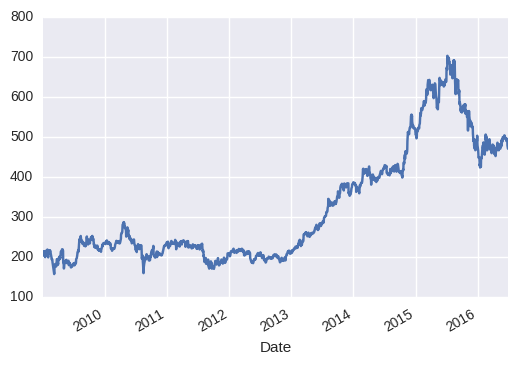

In [454]:
stock_dict[test_sym]['Adj'].plot()

In [448]:
for i, symbol in enumerate(symbol_list):
#     test_sym = 'AMAT'
# pd.Series(prediction_dict['ZBH']).describe()
    print(i, r2_score(y_true_dict[symbol], prediction_dict[symbol]))

0 0.996490427049
1 0.997209674448
2 0.993042978013
3 0.998702059262
4 0.997380754657
5 0.994752027257
6 -1.2626206891e+211
7 0.999269347523
8 0.998363424511
9 -5.76511314947e+95
10 0.99741267208
11 0.995377230911
12 0.998856933594
13 0.997515182054
14 0.991036875127
15 0.994415451255
16 0.98936223501
17 0.995261415271
18 0.999336807995
19 0.990636364808
20 0.998663513869
21 0.997423715652
22 0.997836328256
23 0.998732453244
24 0.997254952012
25 0.999285114003
26 0.998968476992
27 0.998032741918
28 0.998218586502
29 0.999175440835
30 0.999055474331
31 0.999347060147
32 0.994083602984
33 0.999019011848
34 0.998567529085
35 0.997398168349
36 0.998797276373
37 0.99874948727
38 0.998103664548
39 0.993504022988
40 0.990925828713
41 0.99470753
42 -1054804.20475
43 0.997565996227
44 0.998456673831
45 0.9989902157
46 0.999216778331
47 0.998043114552
48 0.997402782254
49 0.996506726796
50 0.99884440159
51 0.996999510025
52 0.998448331722
53 0.997460829562
54 0.998801912523
55 0.998871775463
56 0

In [441]:
pd.options.display.max_rows = 5000

display(kalman_series)

0       9.946397e-01
1       9.973982e-01
2       9.958508e-01
3       9.969861e-01
4       9.984820e-01
5       9.992384e-01
6       9.967305e-01
7       9.994704e-01
8       9.972550e-01
9       9.985499e-01
10      9.969090e-01
11      9.978783e-01
12      9.950343e-01
13      9.980861e-01
14      9.983971e-01
15      9.971285e-01
16      9.978609e-01
17      9.933531e-01
18      9.991773e-01
19      9.966807e-01
20      9.980433e-01
21      9.853800e-01
22      9.982633e-01
23      9.989766e-01
24      9.990345e-01
25      9.978137e-01
26      9.930430e-01
27      9.966820e-01
28      9.973917e-01
29      9.960998e-01
30      9.938672e-01
31      9.938325e-01
32      9.975112e-01
33      9.987255e-01
34      9.985862e-01
35     -4.495956e+27
36      9.973070e-01
37    -1.974468e+225
38      9.981390e-01
39      9.986748e-01
40      9.989328e-01
41      9.987262e-01
42      9.978752e-01
43      9.965366e-01
44      9.995155e-01
45    -4.596359e+167
46      9.917107e-01
47      9.931

In [423]:
print("AVG: {0} {1}".format(naive_avg, kalman_avg))
print("STD: {0} {1}".format(naive_std, kalman_std))

AVG: 0.9933324199649074 -9.740633052916249e+280
STD: 0.04087789840998571 inf


### Analyze and find R

In [260]:
adj_jpm['Adj Close shift'] = adj_jpm['Adj Close'].shift(-1)
adj_jpm['Open shift'] = adj_jpm['Open'].shift(-1)

In [261]:
adj_jpm.head()

,Open,High,Low,Close,Volume,Adj Close,Adj Close shift,Open shift
1983-12-30,2.602623,2.632198,2.573048,44.000008,3.575624e+06,2.602623,2.602623,2.598926
1984-01-03,2.598926,2.617409,2.580440,44.000008,6.517272e+06,2.602623,2.713529,2.652532
1984-01-04,2.652532,2.713529,2.617410,45.874979,4.945011e+06,2.713529,2.802256,2.768984
1984-01-05,2.768984,2.802256,2.735712,47.375008,5.817363e+06,2.802256,2.772681,2.772681
1984-01-06,2.772681,2.802256,2.743106,46.875014,3.286531e+06,2.772681,2.780073,2.780073


In [262]:
adj_jpm['high_diff'] = adj_jpm['High'] - adj_jpm['Adj Close shift']
adj_jpm['low_diff'] = adj_jpm['Low'] - adj_jpm['Adj Close shift']
adj_jpm['close_diff'] = adj_jpm['Adj Close'] - adj_jpm['Adj Close shift']
adj_jpm['open_diff'] = adj_jpm['Open shift'] - adj_jpm['Adj Close shift']

In [263]:
adj_jpm.head()

,Open,High,Low,Close,Volume,Adj Close,Adj Close shift,Open shift,high_diff,low_diff,close_diff,open_diff
1983-12-30,2.602623,2.632198,2.573048,44.000008,3.575624e+06,2.602623,2.602623,2.598926,0.029575,-0.029575,0.000000,-0.003697
1984-01-03,2.598926,2.617409,2.580440,44.000008,6.517272e+06,2.602623,2.713529,2.652532,-0.096120,-0.133089,-0.110906,-0.060997
1984-01-04,2.652532,2.713529,2.617410,45.874979,4.945011e+06,2.713529,2.802256,2.768984,-0.088727,-0.184846,-0.088727,-0.033272
1984-01-05,2.768984,2.802256,2.735712,47.375008,5.817363e+06,2.802256,2.772681,2.772681,0.029575,-0.036969,0.029575,0.000000
1984-01-06,2.772681,2.802256,2.743106,46.875014,3.286531e+06,2.772681,2.780073,2.780073,0.022183,-0.036967,-0.007392,0.000000


In [264]:
adj_jpm.dropna(inplace=True)

In [265]:
adj_jpm.shape

(8255, 12)

In [266]:
high_var126 = adj_jpm.ix[:125, 'high_diff'].std()**2
low_var126 = adj_jpm.ix[:125, 'low_diff'].std()**2
close_var126 = adj_jpm.ix[:125, 'close_diff'].std()**2
open_var126 = adj_jpm.ix[:125, 'open_diff'].std()**2

In [267]:
print(high_var126)
print(low_var126)
print(close_var126)
print(open_var126)

0.00412314952443
0.00367481436698
0.00246559162844
0.00151462039594


In [268]:
init_price = adj_jpm.ix[0, 0]

# kalman = Kalman(init_price, [high_var, low_var, close_var, open_var])
kalman = Kalman(init_price)

In [269]:
prediction = []
counter = 0

for i, r in adj_jpm.iterrows():
    (u,) = adj_jpm.index.get_indexer_for([i])

    # Keep track of number of days
    counter += 1
    # Start from the 127th day of data
    if counter > 126:
        # Calculate variance
        high_var126 = adj_jpm.ix[u-126:u, 'high_diff'].std()**2
        low_var126 = adj_jpm.ix[u-126:u, 'low_diff'].std()**2
        close_var126 = adj_jpm.ix[u-126:u, 'close_diff'].std()**2
        open_var126 = adj_jpm.ix[u-126:u, 'open_diff'].std()**2
        
        kalman.R_h = high_var126
        kalman.R_l = low_var126 
        kalman.R_c = close_var126
        kalman.R_o = open_var126
        
        # Predict
        kalman.predict()

        # Measurement Update
        # Update using High
        kalman.update(measurement=r['High'], sensor_type='high')

        # Update using High
        kalman.update(measurement=r['Low'], sensor_type='high')

        # Update using High
        kalman.update(measurement=r['Adj Close'], sensor_type='close')

        # Update using High
        kalman.update(measurement=r['Open shift'], sensor_type='open')

        prediction.append(kalman.x[0])
        
        if u >= 206 + 126 and u < 217 + 126:
            print("u, i: {}".format((u, i)))
            print("x: {}".format(kalman.x))
            print("P: {}".format(kalman.P))
            print("y: {}".format(kalman.y))
            print("S: {}".format(kalman.S))
            print("K: {}".format(kalman.K))
            print('\n')

u, i: (332, Timestamp('1985-04-24 00:00:00'))
x: [   3.94660664 -555.62886502]
P: [[  3.00552667e+06   2.16764963e+04]
 [  2.17723513e+04   2.09413406e+02]]
y: -3.5553000010679625e-07
S: -21772.03736467683
K: [   1.0000001   138.04525057]


u, i: (333, Timestamp('1985-04-25 00:00:00'))
x: [   3.93439    -556.70771973]
P: [[  3.04918675e+06   2.18859157e+04]
 [  2.19825867e+04   2.10419321e+02]]
y: 1.0909495529176638e-11
S: -21982.274011079444
K: [   1.0000001   138.71114682]


u, i: (334, Timestamp('1985-04-26 00:00:00'))
x: [   3.90995059 -559.52550755]
P: [[  3.09326749e+06   2.20963409e+04]
 [  2.21938287e+04   2.11425212e+02]]
y: -0.024439408059276246
S: -22193.51549586603
K: [   1.0000001   139.37707084]


u, i: (335, Timestamp('1985-04-29 00:00:00'))
x: [   3.86107879 -564.08532014]
P: [[  3.13777093e+06   2.23077721e+04]
 [  2.24060942e+04   2.12431199e+02]]
y: 0.024439786080887593
S: -22405.77253301764
K: [   1.0000001   140.04295561]


u, i: (336, Timestamp('1985-04-30 00:00:0

In [270]:
from copy import copy

adj_jpm_sub = copy(adj_jpm.iloc[126:])

In [271]:
len(adj_jpm_sub)

8129

In [272]:
adj_jpm_sub.ix[:, 'kalman_pred'] = prediction

In [273]:
adj_jpm_sub.iloc[200:300]

,Open,High,Low,Close,Volume,Adj Close,Adj Close shift,Open shift,high_diff,low_diff,close_diff,open_diff,kalman_pred
1985-04-16,3.934390,3.934390,3.873295,39.99999,3.151957e+06,3.909951,3.971046,3.909951,-3.665585e-02,-9.775080e-02,-0.061095,-0.061095,3.909951
1985-04-17,3.909951,3.983263,3.897734,40.62501,3.050677e+06,3.971046,3.958826,3.995482,2.443665e-02,-6.109160e-02,0.012220,0.036656,3.995482
1985-04-18,3.995482,3.995482,3.934390,40.50000,2.025601e+06,3.958826,3.958826,3.958826,3.665580e-02,-2.443622e-02,0.000000,0.000000,3.958826
1985-04-19,3.958826,3.971046,3.934390,40.50000,2.596452e+06,3.958826,3.922170,3.934390,4.887558e-02,1.221978e-02,0.036656,0.012220,3.934390
1985-04-22,3.934390,3.946606,3.922170,40.12500,2.679317e+06,3.922170,3.971046,3.909951,-2.443978e-02,-4.887600e-02,-0.048876,-0.061095,3.909951
1985-04-23,3.909951,3.971046,3.909951,40.62501,2.551029e+07,3.971046,3.946607,3.983263,2.443900e-02,-3.665596e-02,0.024439,0.036656,3.983263
1985-04-24,3.983263,3.995482,3.946607,40.37499,6.264015e+06,3.946607,3.934390,3.946607,6.109238e-02,1.221700e-02,0.012217,0.012217,3.946607
1985-04-25,3.946607,3.958826,3.922170,40.25001,3.507972e+06,3.934390,3.934390,3.934390,2.443622e-02,-1.221958e-02,0.000000,0.000000,3.934390
1985-04-26,3.934390,3.946607,3.922170,40.25001,1.770866e+06,3.934390,3.836639,3.909951,1.099676e-01,8.553142e-02,0.097751,0.073312,3.909951
1985-04-29,3.909951,3.909951,3.824422,39.24999,1.439404e+06,3.836639,3.702236,3.861079,2.077146e-01,1.221864e-01,0.134403,0.158843,3.861079


In [274]:
from datetime import datetime

adj_jpm_sub.index.get_indexer_for([datetime(1985, 4, 25)])

array([207])

In [275]:
adj_jpm_sub.isnull().sum()

Open               0
High               0
Low                0
Close              0
Volume             0
Adj Close          0
Adj Close shift    0
Open shift         0
high_diff          0
low_diff           0
close_diff         0
open_diff          0
kalman_pred        0
dtype: int64

In [276]:
from sklearn.metrics import r2_score

y_true = adj_jpm_sub['Adj Close shift']

naive = r2_score(y_true, adj_jpm_sub['Adj Close'])
kalman_pred = r2_score(y_true, prediction)

In [277]:
print(naive)
print(kalman_pred)

0.998779271109
0.999135646002


In [278]:
naive_df = pd.DataFrame(adj_jpm_sub['Adj Close'])
naive_df['Adj_Close'] = adj_jpm_sub['Adj Close shift']

In [279]:
naive_df.columns = ['Naive', 'Adj_Close']

In [280]:
naive_df.head()

,Naive,Adj_Close
1984-06-29,2.220009,2.254697
1984-07-02,2.254697,2.335636
1984-07-03,2.335636,2.370323
1984-07-05,2.370323,2.335636
1984-07-06,2.335636,2.451259


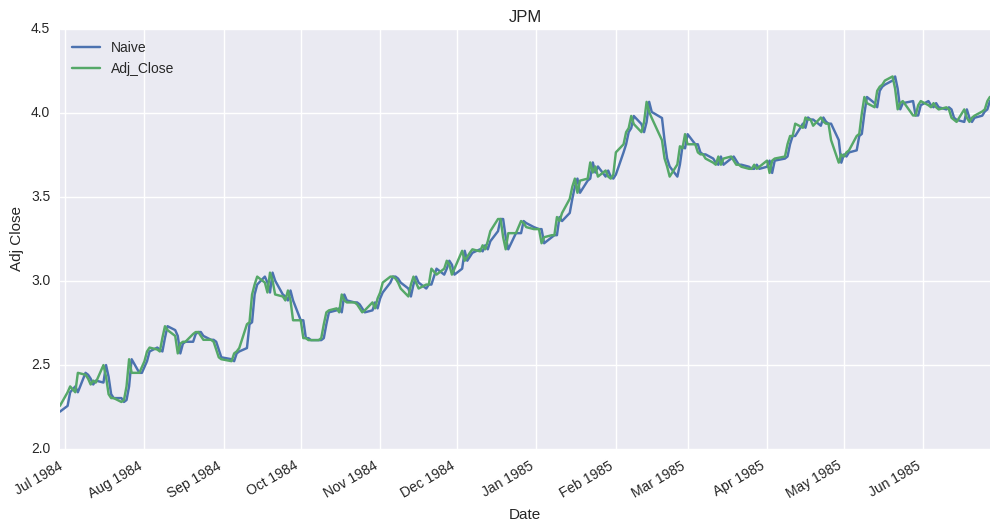

In [281]:
ax = naive_df.ix[0:252, :].plot(figsize=(12, 6), title='JPM')
ax.set_xlabel("Date")
ax.set_ylabel("Adj Close")
plt.show()

In [282]:
kalman_df = pd.DataFrame(adj_jpm_sub['kalman_pred'])
kalman_df['Adj_Close'] = adj_jpm_sub['Adj Close shift']
kalman_df.columns = ['Kalman', 'Adj_Close']

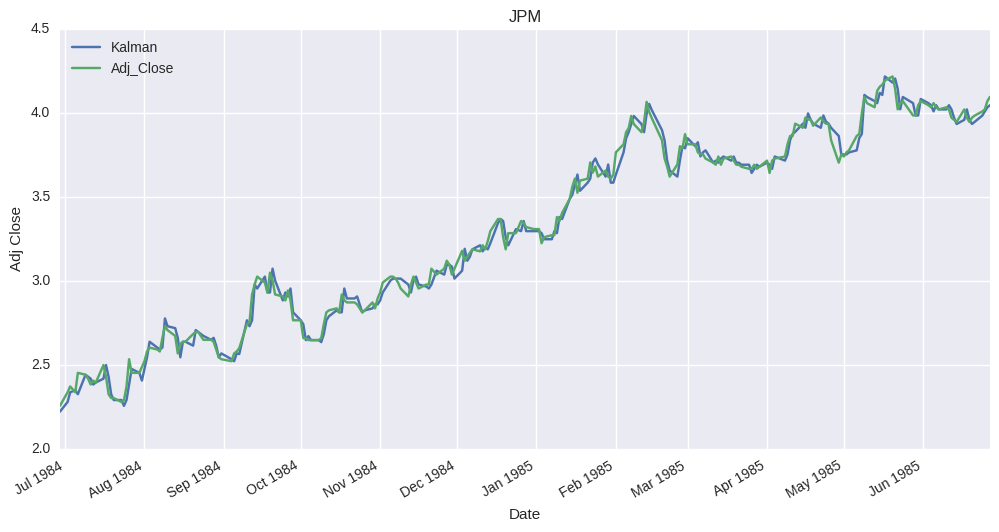

In [283]:
ax = kalman_df.ix[0:252, :].plot(figsize=(12, 6), title='JPM')
ax.set_xlabel("Date")
ax.set_ylabel("Adj Close")
plt.show()

In [405]:
adj_jpm_sub.head()

,Open,High,Low,Close,Volume,Adj Close,Adj Close shift,Open shift,high_diff,low_diff,close_diff,open_diff,kalman_pred
1984-06-29,2.208446,2.254697,2.173758,24.00000,7.832401e+06,2.220009,2.254697,2.220009,-3.593700e-07,-8.093911e-02,-0.034688,-0.034688,2.220009
1984-07-02,2.220009,2.277821,2.196885,24.37500,5.756733e+06,2.254697,2.335636,2.277821,-5.781483e-02,-1.387508e-01,-0.080939,-0.057815,2.277833
1984-07-03,2.277821,2.358760,2.277821,25.25001,5.708083e+06,2.335636,2.370323,2.335635,-1.156283e-02,-9.250160e-02,-0.034687,-0.034688,2.335635
1984-07-05,2.335635,2.370323,2.335635,25.62501,9.502664e+05,2.370323,2.335636,2.347197,3.468700e-02,-6.401200e-07,0.034687,0.011561,2.347193
1984-07-06,2.347197,2.358760,2.324073,25.25001,1.212968e+06,2.335636,2.451259,2.324072,-9.249883e-02,-1.271865e-01,-0.115623,-0.127187,2.324071
